In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
batch_size = 128
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_indices = list(range(len(data)))[:40000]
validation_indices = list(range(len(data)))[40000:]

# train_sample = torch.utils.data.SubsetRandomSampler(train_indices)
# validation_sample = torch.utils.data.SubsetRandomSampler(validation_indices)


# Subsets of the whole train data using the sampled indices
trainset = torch.utils.data.Subset(data, train_indices)
validationset = torch.utils.data.Subset(data, validation_indices)

# Dataloader using the created subsets
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

validationloader = torch.utils.data.DataLoader(validationset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
len(validationset)

10000

In [4]:
print('Train set size: ', len(trainloader) * 4)
print('Validation set size: ', len(validationloader) * 4)
print('Test set size: ', len(testloader) * 4)

Train set size:  1252
Validation set size:  316
Test set size:  316


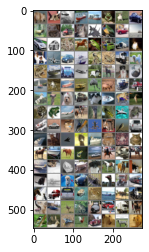

  dog   cat plane  ship  ship  frog   dog   car  deer  frog truck   cat plane  bird   car  ship   car   car  frog horse  frog   car truck   cat   dog plane   car  ship  bird  frog truck   dog  frog  ship truck plane   dog horse   dog   cat  ship  frog  ship plane  bird  deer truck truck horse  bird   dog truck   dog  ship   dog  deer  frog  frog plane horse  deer  bird plane  frog  ship   car   cat  bird  frog   cat  bird   car  ship   cat plane  bird  ship   cat  frog   cat horse  ship horse  frog   car horse   dog horse plane   cat  ship  ship   dog horse horse   cat   cat plane   dog   car   cat  bird truck truck horse truck   car  frog  frog  ship  deer truck   dog   car  bird  frog   car   car truck   dog  bird  deer plane  bird truck   cat horse   dog


In [5]:
# The function to show an image.
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images.
dataiter = iter(trainloader)
images, labels = next(dataiter)
# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

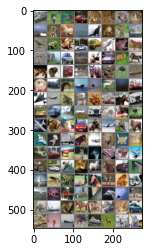

  car  bird  deer   car  frog  frog  frog   dog truck  bird horse  ship   cat  frog   cat  ship  bird  frog  frog   car truck plane  frog horse  deer  bird   car  deer  deer  ship  deer horse   dog  bird truck   cat horse  frog  bird  ship   dog truck horse  ship  bird horse  deer  ship plane plane  frog   dog  deer   car horse   car  ship   car  deer plane   car   dog   cat  deer plane  frog   dog   car horse plane  bird  deer plane   dog truck horse plane  bird   cat   cat truck truck horse  deer  bird  frog   dog plane truck   car plane   cat   dog horse truck horse  ship  deer  frog  bird horse horse  frog truck  ship  frog truck  deer   cat horse plane horse   dog  ship   cat horse   cat   car  bird   car  frog   cat  ship  deer  ship  deer  deer   cat


In [6]:
# Get some random valldation images.
dataiter = iter(validationloader)
images, labels = next(dataiter)
# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [7]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


In [8]:
class NetMod(nn.Module):
    def __init__(self):
        super(NetMod, self).__init__()
        self.avgpool = nn.AvgPool2d(kernel_size=(8,8))
        
        self.filter1 = 16
        self.filter2 = 32
        self.filter3 = 64
        
        self.convinit = nn.Conv2d(in_channels=3, out_channels=self.filter1, kernel_size=3, stride=1, padding=1)
        
        self.conv1 = nn.Conv2d(in_channels=self.filter1, out_channels=self.filter1, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=self.filter1, out_channels=self.filter1, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=self.filter1, out_channels=self.filter1, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=self.filter1, out_channels=self.filter1, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=self.filter1, out_channels=self.filter1, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=self.filter1, out_channels=self.filter1, kernel_size=3, stride=1, padding=1)
        self.projection1 = nn.Conv2d(in_channels=self.filter1, out_channels=self.filter2, kernel_size=1, stride=2)
        
        self.conv7 = nn.Conv2d(in_channels=self.filter1, out_channels=self.filter2, kernel_size=3, stride=2, padding=1)
        self.conv8 = nn.Conv2d(in_channels=self.filter2, out_channels=self.filter2, kernel_size=3, stride=1, padding=1)
        self.conv9 = nn.Conv2d(in_channels=self.filter2, out_channels=self.filter2, kernel_size=3, stride=1, padding=1)
        self.conv10 = nn.Conv2d(in_channels=self.filter2, out_channels=self.filter2, kernel_size=3, stride=1, padding=1)
        self.conv11 = nn.Conv2d(in_channels=self.filter2, out_channels=self.filter2, kernel_size=3, stride=1, padding=1)
        self.conv12 = nn.Conv2d(in_channels=self.filter2, out_channels=self.filter2, kernel_size=3, stride=1, padding=1)
        self.projection2 = nn.Conv2d(in_channels=self.filter2, out_channels=self.filter3, kernel_size=1, stride=2)
        
        self.conv13 = nn.Conv2d(in_channels=self.filter2, out_channels=self.filter3, kernel_size=3, stride=2, padding=1)
        self.conv14 = nn.Conv2d(in_channels=self.filter3, out_channels=self.filter3, kernel_size=3, stride=1, padding=1)
        self.conv15 = nn.Conv2d(in_channels=self.filter3, out_channels=self.filter3, kernel_size=3, stride=1, padding=1)
        self.conv16 = nn.Conv2d(in_channels=self.filter3, out_channels=self.filter3, kernel_size=3, stride=1, padding=1)
        self.conv17 = nn.Conv2d(in_channels=self.filter3, out_channels=self.filter3, kernel_size=3, stride=1, padding=1)
        self.conv18 = nn.Conv2d(in_channels=self.filter3, out_channels=self.filter3, kernel_size=3, stride=1, padding=1)
        
        self.batchnorminit = nn.BatchNorm2d(self.filter1)
        self.batchnorm1 = nn.BatchNorm2d(self.filter1)
        self.batchnorm2 = nn.BatchNorm2d(self.filter1)
        self.batchnorm3 = nn.BatchNorm2d(self.filter1)
        self.batchnorm4 = nn.BatchNorm2d(self.filter1)
        self.batchnorm5 = nn.BatchNorm2d(self.filter1)
        self.batchnorm6 = nn.BatchNorm2d(self.filter1)
        self.batchnorm7 = nn.BatchNorm2d(self.filter2)
        self.batchnorm8 = nn.BatchNorm2d(self.filter2)
        self.batchnorm9 = nn.BatchNorm2d(self.filter2)
        self.batchnorm10 = nn.BatchNorm2d(self.filter2)
        self.batchnorm11 = nn.BatchNorm2d(self.filter2)
        self.batchnorm12 = nn.BatchNorm2d(self.filter2)
        self.batchnorm13 = nn.BatchNorm2d(self.filter3)
        self.batchnorm14 = nn.BatchNorm2d(self.filter3)
        self.batchnorm15 = nn.BatchNorm2d(self.filter3)
        self.batchnorm16 = nn.BatchNorm2d(self.filter3)
        self.batchnorm17 = nn.BatchNorm2d(self.filter3)
        self.batchnorm18 = nn.BatchNorm2d(self.filter3)
        
        
        self.fc1 = nn.Linear(in_features=self.filter3, out_features=10)
        
    def forward(self, x):
        ##### n = 3
        ##### first 3x3 conv layer
        x = self.convinit(x)
        x = self.batchnorminit(x)
        x = F.relu(x)
        
        ##### 2n layers for 32x32 features
        x1 = self.conv1(x)
        x1 = self.batchnorm1(x1)
        x1 = F.relu(x1)
        
        x2 = self.conv2(x1)
        x2 = self.batchnorm2(x2)
        x2 = x2 + x1
        x2 = F.relu(x2)
        
        x3 = self.conv3(x2)
        x3 = self.batchnorm3(x3)
        x3 = F.relu(x3)
        
        x4 = self.conv4(x3)
        x4 = self.batchnorm4(x4)
        x4 = x4 + x2
        x4 = F.relu(x4)
        
        x5 = self.conv5(x4)
        x5 = self.batchnorm5(x5)
        x5 = F.relu(x5)
        
        x6 = self.conv6(x5)
        x6 = self.batchnorm6(x6)
        x6 = x6 + x4
        x6 = F.relu(x6)
        
        ##### 2n layers for 16x16 features
        x7 = self.conv7(x6)
        x7 = self.batchnorm7(x7)
        x7 = F.relu(x7)
        
        x8 = self.conv8(x7)
        x8 = self.batchnorm8(x8)
        x8 = x8 + self.projection1(x6)
        x8 = F.relu(x8)
        
        x9 = self.conv9(x8)
        x9 = self.batchnorm9(x9)
        x9 = F.relu(x9)
        
        x10 = self.conv10(x9)
        x10 = self.batchnorm10(x10)
        x10 = x10 + x8
        x10 = F.relu(x10)
        
        x11 = self.conv11(x10)
        x11 = self.batchnorm11(x11)
        x11 = F.relu(x11)
        
        x12 = self.conv12(x11)
        x12 = self.batchnorm12(x12)
        x12 = x12 + x10
        x12 = F.relu(x12)
        
        #### 2n layers for 8x8 features
        x13 = self.conv13(x12)
        x13 = self.batchnorm13(x13)
        x13 = F.relu(x13)
        
        x14 = self.conv14(x13)
        x14 = self.batchnorm14(x14)
        x14 = x14 + self.projection2(x12)
        x14 = F.relu(x14)
        
        x15 = self.conv15(x14)
        x15 = self.batchnorm15(x15)
        x15 = F.relu(x15)
        
        x16 = self.conv16(x15)
        x16 = self.batchnorm16(x16)
        x16 = x16 + x14
        x16 = F.relu(x16)
        
        x17 = self.conv17(x16)
        x17 = self.batchnorm17(x17)
        x17 = F.relu(x17)
        
        x18 = self.conv18(x17)
        x18 = self.batchnorm18(x18)
        x18 = x18 + x16
        x18 = F.relu(x18)
        
        # avg pool and linear layer
        x19 = self.avgpool(x18)
        x19 = torch.flatten(x19, 1)
        x19 = self.fc1(x19)
        return x19

net = NetMod()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

NetMod(
  (avgpool): AvgPool2d(kernel_size=(8, 8), stride=(8, 8), padding=0)
  (convinit): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (projection1): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2))
  (conv7): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (con

In [9]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use stochastic gradient descent (SGD) as optimizer.
opt = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', patience=2, threshold=0.01, verbose=True)

In [10]:
avg_losses = []   # Avg. losses.
validation_losses = []
epochs = 90       # Total epochs.
print_freq = 100  # Print frequency.
lr_list = set()
valid_losses = []

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    validation_loss = 0.0
    
    net.train()
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq    
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

    net.eval()
    with torch.no_grad():
        for i, data in enumerate(validationloader, 0):
            # Get the inputs.
            inputs, labels = data

            # Move the inputs to the specified device.
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward step.
            outputs = net(inputs)
            loss = loss_func(outputs, labels)
            validation_loss += loss.item()
            validation_losses.append(validation_loss)
    net.train()
    
    # If validation error no longer improve, divide the lr by 10
    scheduler.step(validation_loss)
    print('Validation Loss: ', validation_loss)
    valid_losses.append(validation_loss)
    lr_list.add(scheduler._last_lr[0])
                            

print('Finished Training.')
print('LR list: ', lr_list)

[epoch: 0, i:    99] avg mini-batch loss: 1.9230872631072997
[epoch: 0, i:   199] avg mini-batch loss: 1.6664605712890626
[epoch: 0, i:   299] avg mini-batch loss: 1.5275685465335846
Validation Loss:  133.67160099744797
[epoch: 1, i:    99] avg mini-batch loss: 1.3231743371486664
[epoch: 1, i:   199] avg mini-batch loss: 1.205752249956131
[epoch: 1, i:   299] avg mini-batch loss: 1.0898060613870622
Validation Loss:  93.52300417423248
[epoch: 2, i:    99] avg mini-batch loss: 0.9737306940555572
[epoch: 2, i:   199] avg mini-batch loss: 0.8969571280479431
[epoch: 2, i:   299] avg mini-batch loss: 0.8817355108261108
Validation Loss:  69.43190169334412
[epoch: 3, i:    99] avg mini-batch loss: 0.7774191999435425
[epoch: 3, i:   199] avg mini-batch loss: 0.7574799805879593
[epoch: 3, i:   299] avg mini-batch loss: 0.7552091455459595
Validation Loss:  63.3668909072876
[epoch: 4, i:    99] avg mini-batch loss: 0.6682209730148315
[epoch: 4, i:   199] avg mini-batch loss: 0.6487499144673348
[ep

Validation Loss:  47.75009560585022
[epoch: 35, i:    99] avg mini-batch loss: 0.06391782289370894
[epoch: 35, i:   199] avg mini-batch loss: 0.060168007742613556
[epoch: 35, i:   299] avg mini-batch loss: 0.06439970018342138
Validation Loss:  47.55144655704498
[epoch: 36, i:    99] avg mini-batch loss: 0.06573842654004693
[epoch: 36, i:   199] avg mini-batch loss: 0.0592107149772346
[epoch: 36, i:   299] avg mini-batch loss: 0.0628243650496006
Validation Loss:  47.2716546356678
[epoch: 37, i:    99] avg mini-batch loss: 0.06017113598063588
[epoch: 37, i:   199] avg mini-batch loss: 0.06447640618309379
[epoch: 37, i:   299] avg mini-batch loss: 0.0652542662806809
Validation Loss:  47.679315745830536
[epoch: 38, i:    99] avg mini-batch loss: 0.060530986115336416
[epoch: 38, i:   199] avg mini-batch loss: 0.06578511474654078
[epoch: 38, i:   299] avg mini-batch loss: 0.06226116508245468
Validation Loss:  47.39174145460129
[epoch: 39, i:    99] avg mini-batch loss: 0.06339020280167461
[e

[epoch: 71, i:   199] avg mini-batch loss: 0.06553392237052322
[epoch: 71, i:   299] avg mini-batch loss: 0.06505294354632497
Validation Loss:  47.316174268722534
[epoch: 72, i:    99] avg mini-batch loss: 0.05813523394986987
[epoch: 72, i:   199] avg mini-batch loss: 0.06435878105461597
[epoch: 72, i:   299] avg mini-batch loss: 0.06577355120331049
Validation Loss:  47.468160569667816
[epoch: 73, i:    99] avg mini-batch loss: 0.06506945947185158
[epoch: 73, i:   199] avg mini-batch loss: 0.060648323372006416
[epoch: 73, i:   299] avg mini-batch loss: 0.065497751776129
Validation Loss:  47.29594561457634
[epoch: 74, i:    99] avg mini-batch loss: 0.06252807170152665
[epoch: 74, i:   199] avg mini-batch loss: 0.06213931355625391
[epoch: 74, i:   299] avg mini-batch loss: 0.06174395052716136
Validation Loss:  48.040795981884
[epoch: 75, i:    99] avg mini-batch loss: 0.06534584630280733
[epoch: 75, i:   199] avg mini-batch loss: 0.06276444863528013
[epoch: 75, i:   299] avg mini-batch l

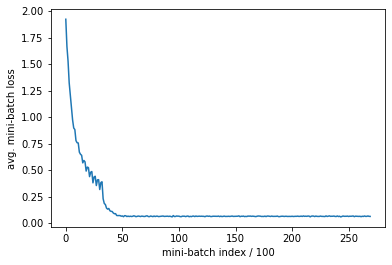

In [11]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

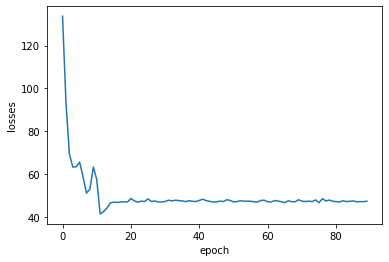

In [12]:
plt.plot(valid_losses)
plt.xlabel('epoch')
plt.ylabel('losses')
plt.show()

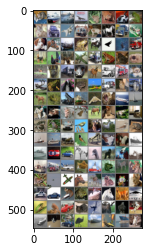

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog  deer   dog truck  bird  deer   car truck   dog  deer  frog   dog  frog plane truck   cat truck horse  frog truck  ship plane   cat  ship  ship horse horse  deer  frog horse   cat  frog   cat  frog  bird   car  bird   cat horse  bird  frog  ship  ship plane  bird truck   cat   cat  ship  ship   car   car horse  bird   dog  bird horse  ship truck plane   cat  ship  frog  deer  frog  frog plane plane horse  deer   dog  frog   cat   car   car   cat  frog  ship horse  deer plane  frog  bird   car   cat plane  deer  bird horse  ship   cat   car  bird  ship plane  ship   cat
Predicted:    cat  ship  ship plane  frog  frog truck  deer   cat   car plane truck  deer horse truck  ship   dog horse  ship  frog truck plane  deer truck  deer   cat  deer plane truck  frog  frog   dog  bird   dog tr

NetMod(
  (avgpool): AvgPool2d(kernel_size=(8, 8), stride=(8, 8), padding=0)
  (convinit): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (projection1): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2))
  (conv7): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (con

In [13]:
# Check several images.
net.eval()
with torch.no_grad():
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))
    outputs = net(images.to(device))
    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  for j in range(batch_size)))
net.train()

In [14]:
# Get test accuracy.
correct = 0
total = 0

net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
#         print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))
#         print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
#                               for j in range(batch_size)))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

net.train()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 82 %


In [15]:
total

10000

In [16]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        for i in range(batch_size):
            if i == len(labels):
                break
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 86 %
Accuracy of   car : 91 %
Accuracy of  bird : 73 %
Accuracy of   cat : 64 %
Accuracy of  deer : 80 %
Accuracy of   dog : 75 %
Accuracy of  frog : 85 %
Accuracy of horse : 83 %
Accuracy of  ship : 89 %
Accuracy of truck : 89 %
